MonteCarlo simulation for geometricl efficiency estimation

In [1]:
import numpy as np
from scipy import special as sp
from scipy import constants as c
import matplotlib.pyplot as plt

In [2]:
core_diam = 8.2*1e-6 # meters
lenght = 1 # meters
lam = 1555 * 1e-9 #meters

First we have to compute the number of photons coming out of the diode

In [3]:
P = 1.5*1e-3 #diode power
R0 = (P*lam)/(c.Planck*c.c) # photons per second

Then we have to account for 1m lenght of fiber

In [4]:
fiber_att = pow(10,(0.18/20))*lenght/1000 #W per m
R_in = R0*fiber_att*1e-9 #rate of photons out of fiber in 1 ns

Airy diffraction formula

In [5]:
def airy(theta):
    a=core_diam
    k = 2*np.pi/lam
    x = k*a*np.sin(theta)
    return (2*sp.j1(x)/x)**2

Show plot of Airy formula

Text(0, 0.5, 'Airy')

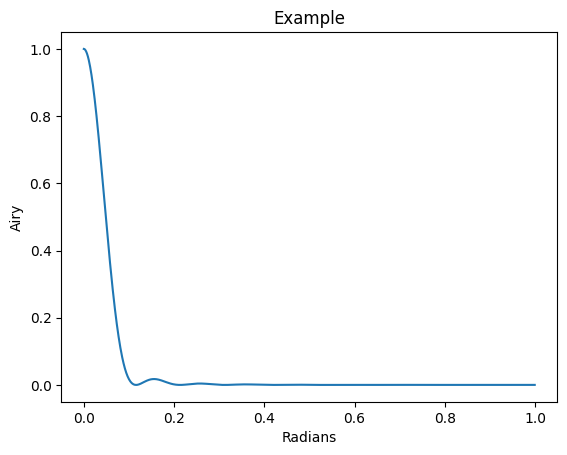

In [6]:
temp = np.arange(0.0001,1,0.001)
plt.plot(temp, airy(temp))
plt.title("Example")
plt.xlabel("Radians")
plt.ylabel("Airy")

In [7]:
z = 1
x = np.arange(0.000001,10,0.001)
ang = np.arctan(x/z)
R_out = R_in*airy(ang)

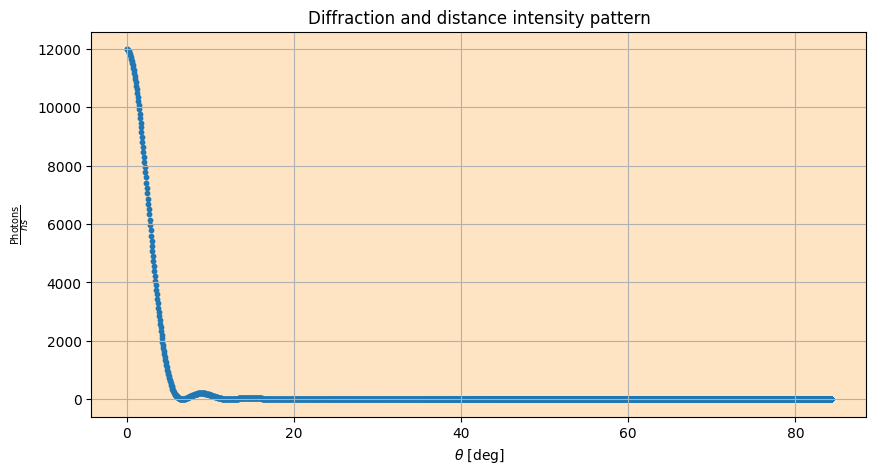

In [8]:
fig, axs = plt.subplots(figsize=(10,5))
plt.scatter(ang/np.pi*180, R_out, marker='o',s=10)
plt.title("Diffraction and distance intensity pattern")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$\frac{\text{Photons}}{ns}$")
plt.grid()
axs.set_facecolor('bisque')
#plt.colorbar(label="Radius dependence %", orientation="vertical") 


In [9]:
z = 1e3

Creating chip active area

In [10]:
x = {'xmin': [i * 1550 + 480 for i in range(8)], 'xmax': [i * 1550 + 730 for i in range(8)]} 

xactives = [(x['xmin'][i],x['xmax'][i]) for i in range(len(x['xmin']))]
yactives = [(1270,2030),(2230,2290)]

yplus = {'ymin': 2230, 'ymax': 2990}
yneg = {'ymin': 1270, 'ymax': 2030}
y = [1270,2030, 2230, 2990]

In [60]:
N = int(1e7)
theta, hit = [], []
count = np.zeros(8)

for n in range(N):
    xax = np.random.uniform(low=0, high=max(x['xmax'])+250)
    yax = np.random.uniform(low=0, high=4265)
    for i in range(8):
        if (x['xmin'][i]<xax and xax<x['xmax'][i]):
            count[i] += 1
            theta.append(np.arctan(np.sqrt(xax**2 + yax**2)/z))

In [61]:
for i in range(len(theta)):
    theta[i] = theta[i] * 180/np.pi

Histogram of counts before airy correction

500


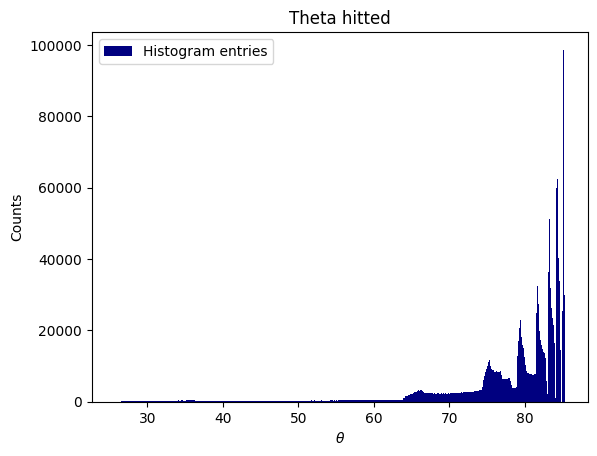

In [62]:
# 1.) Necessary imports.    
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

datab = theta
bin_countb = 500
print(bin_countb)
binsb = np.linspace(min(theta), max(theta), bin_countb)
data_entriesb, binsb = np.histogram(datab, bins=binsb)#, bins=bins)

# 4.) Add histograms of exponential and gaussian data.
binscentersb = np.array([0.5 * (binsb[i] + binsb[i+1]) for i in range(len(binsb)-1)])

# 5.) Fit the function to the histogram data.

# Plot the histogram and the fitted function.
plt.bar(binscentersb, data_entriesb, width=binsb[1] - binsb[0], color='navy', label=r'Histogram entries')
# Make the plot nicer.
#plt.xlim(0,0.08)
plt.xlabel(r"$\theta$")
plt.xticks()
plt.ylabel(r'Counts')
plt.title(r'Theta hitted')
plt.legend(loc='best')

In [63]:
print(binsb[0])

25.642530418795413


In [64]:
heights = []
for (height,theta) in zip(data_entriesb,binsb):
    heights.append(height*airy(theta))

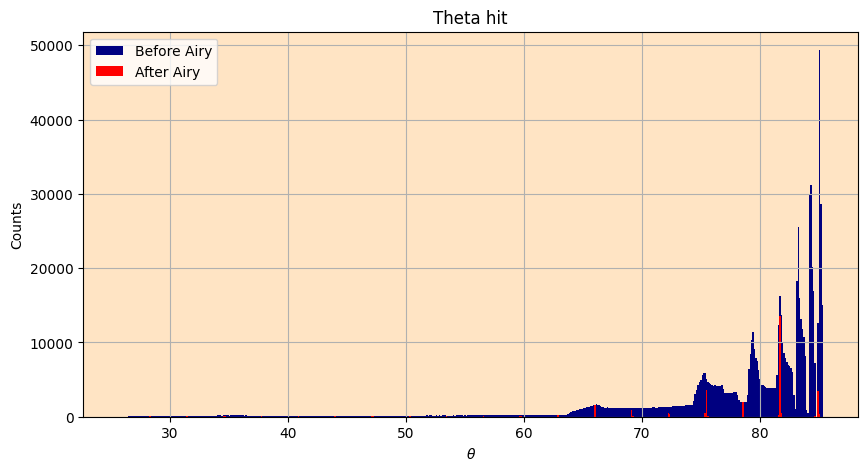

In [72]:
fig, axs = plt.subplots(figsize=(10,5))
axs.set_facecolor("bisque")
plt.bar(binscentersb, np.array(data_entriesb)/2, width=binsb[1] - binsb[0], color='navy', label=r'Before Airy')
plt.bar(binscentersb, np.array(heights)/2, width=binsb[1] - binsb[0], color='red', label=r'After Airy')
# Make the plot nicer.
#plt.xlim(0,0.08)
plt.xlabel(r"$\theta$")
#plt.xlim([83,87])
plt.xticks()
plt.ylabel(r'Counts')
plt.title(r'Theta hit')
plt.legend(loc='best')
plt.grid()